**Description**: This notebook demonstrates how to formulate basic power systems engineering models in JuMP using a 3 bus example. We will consider basic "economic dispatch" and "unit commitment" models without taking into account transmission constraints.

This notebook was developed for the [Grid Science Winter School](http://www.cvent.com/events/grid-science-winter-school-conference/event-summary-229c17f488194f2ebb5b206820974c71.aspx) held in Santa Fe, NM in January 2015.

Note that the notebook contains many interactive features which do not display correctly on read-only links. For the full experience, run this notebook locally or on [JuliaBox](https://juliabox.org/).

**Author**: Yury Dvorkin and Miles Lubin

**License**: <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

## Illustrative example

In the following notes for the sake of simplicity, we are going to use a three bus example mirroring the interface between Western and Eastern Texas. This example is taken from R. Baldick, "[Wind and Energy Markets: A Case Study of Texas](http://dx.doi.org/10.1109/JSYST.2011.2162798)," IEEE Systems Journal, vol. 6, pp. 27-34, 2012. 

<img src="http://i57.tinypic.com/2hn530x.png">

For this example, we set the following characteristics of generators, transmission lines, wind farms and demands:
<table style="width:25%">
  <tr>
    <td></td>
    <td>Generator 1</td> 
    <td>Generator 2</td>
  </tr>
  <tr>
    <td>$g_{min}$, MW</td>
    <td>0</td> 
    <td>300</td> 
  </tr>
  
   <tr>
    <td>$g_{max}$, MW</td>
    <td>1000</td> 
    <td>1000</td> 
  </tr>
  <tr>
    <td>$c^g$, \$/MWh</td>
    <td>50</td> 
    <td>100</td> 
  </tr>
  <tr>
    <td>$c^{g0}$, \$/MWh</td>
    <td>1000</td> 
    <td>0</td> 
  </tr> 
</table>

<table style="width:25%">
  <tr>
    <td></td>
    <td>Line 1</td> 
    <td>Line 2</td>
  </tr>
  <tr>
    <td>$f^{max}$, MW</td>
    <td>100</td> 
    <td>1000</td> 
  </tr>
  <tr>
    <td>x, p.u.</td>
    <td>0.001</td> 
    <td>0.001</td> 
  </tr>
</table>

<table style="width:25%">
  <tr>
    <td></td>
    <td>Wind farm 1</td> 
    <td>Wind farm 2</td>
  </tr>
  <tr>
    <td>$w^{f}$, MW</td>
    <td>150</td> 
    <td>50</td> 
  </tr>
  <tr>
  <td>$c^{w}$, \$/MWh</td>
    <td>50</td> 
    <td>50</td> 
  </tr>
</table>

<table style="width:25%">
  <tr>
    <td></td>
    <td>Bus 1</td> 
    <td>Bus 2</td>
    <td>Bus 3</td>
  </tr>
  <tr>
    <td>$d$, MW</td>
    <td>0</td> 
    <td>0</td> 
    <td>15000</td> 
    
  </tr>
</table>

## Economic dispatch

Economic dispatch (ED) is an optimization problem that minimizes the cost of supplying energy demand subject to operational constraints on power system assets. In its simplest modification, ED is an LP problem solved for an aggregated load and wind forecast and for a single infinitesimal moment. Mathematically, the ED problem can be written as follows:
$$
\min \sum_{i \in I} c^g_{i} \cdot g_{i} + c^w \cdot w,
$$
where $c_{i}$ and $g_{i}$ are the incremental cost ($\$/MWh$) and power output ($MW$) of the $i^{th}$ generator, respectively, and $c^w$ and $w$ are the incremental cost ($\$/MWh$) and wind power injection ($MW$), respectively.


s.t.

<li> Minimum ($g^{\min}$) and maximum ($g^{\max}$) limits on power outputs of generators: </li>
$$
g^{\min}_{i} \leq g_{i} \leq g^{\max}_{i}.
$$
<li>Constraint on the wind power injection:</li>
$$
0 \leq w \leq w^f, 
$$
where $w$ and $w^f$ are the wind power injection and wind power forecast, respectively.

<li>Power balance constraint:</li>
$$
\sum_{i \in I} g_{i} + w = d^f, 
$$
where $d^f$ is the demand forecast.

Further reading on ED models can be found in A. J. Wood, B. F. Wollenberg, and G. B. Sheblé, "Power Generation, Operation and Control", Wiley, 2013.

## JuMP Implementation of Economic Dispatch 

In [1]:
# Define the packages 
using JuMP # used for mathematical programming
using Interact # used for enabling the slider
using Plots # used for plotting 
gr();

In [2]:
# Define some input data about the test system
# Maximum power output of generators
const g_max = [1000,1000];
# Minimum power output of generators
const g_min = [0,300];
# Incremental cost of generators 
const c_g = [50,100];
# Fixed cost of generators
const c_g0 = [1000,0]
# Incremental cost of wind generators
const c_w = 50;
# Total demand
const d = 1500;
# Wind forecast
const w_f = 200;

In [3]:
# In this cell we create  function solve_ed, which solves the economic dispatch problem for a given set of input parameters.
function solve_ed(g_max, g_min, c_g, c_w, d, w_f)
    #Define the economic dispatch (ED) model
    ed=Model() 
    
    # Define decision variables    
    @variable(ed, g_min[i] <= g[i=1:2] <= g_max[i]) # power output of generators
    @variable(ed, 0 <= w  <= w_f ) # wind power injection

    # Define the objective function
    @objective(ed,Min,sum(c_g[i] * g[i] for i=1:2)+ c_w * w)

    # Define the power balance constraint
    @constraint(ed, sum(g[i] for i=1:2) + w == d)

    # Solve statement
    solve(ed)
    
    # return the optimal value of the objective function and its minimizers
    return getvalue(g), getvalue(w), w_f-getvalue(w), getobjectivevalue(ed)
end

# Solve the economic dispatch problem
(g_opt,w_opt,ws_opt,obj)=solve_ed(g_max, g_min, c_g, c_w, d, w_f);

println("\n")
println("Dispatch of Generators: ", g_opt, " MW")
println("Dispatch of Wind: ", w_opt, " MW")
println("Wind spillage: ", w_f-w_opt, " MW") 
println("\n")
println("Total cost: ", obj, "\$")  



Dispatch of Generators: [1000.0,300.0] MW
Dispatch of Wind: 200.0 MW
Wind spillage: 0.0 MW


Total cost: 90000.0$


### Economic dispatch with adjustable incremental costs

In the following exercise we adjust the incremental cost of generator G1 and observe its impact on the total cost by using the manipulator

In [4]:
# This cell uses the package Interact defined above. 
# In this cell we create a manipulator that solves the economic dispatch problem for different values of c_g1_scale.

@manipulate for c_g1_scale = 0.5:0.01:3.0
    c_g_scale = [c_g[1]*c_g1_scale, c_g[2]] # update the incremental cost of the first generator at every iteration
    g_opt,w_opt,ws_opt,obj = solve_ed(g_max, g_min, c_g_scale, c_w, d, w_f) # solve the ed problem with the updated incremental cost
    HTML("Dispatch of Generators, MW: $(g_opt[:])<br>"*
    "Dispatch of Wind, MW: $w_opt<br>"*
    "Spillage of Wind, MW: $ws_opt<br>"*
    "Total cost, \$: $obj")
end

Interact.Slider{Float64}(Signal{Float64}(1.75, nactions=0),"c_g1_scale",1.75,0.5:0.01:3.0,".3f",true)

HTML{String}("Dispatch of Generators, MW: [1000.0,300.0]<br>Dispatch of Wind, MW: 200.0<br>Spillage of Wind, MW: 0.0<br>Total cost, \$: 127500.0")

#### Impact of the wind generation cost 

In the following exercise we introduce a new manipulator to vary the cost of wind generation and observe its impact the total cost, dispatch of generators G1 and G2, utilization of available wind under different values of the incremental cost of generator G1.

In [5]:
@manipulate for c_w_scale = 1:0.1:3.5
    # Define the vectors of outputs
    obj_out = Float64[] 
    w_out = Float64[]
    g1_out = Float64[]
    g2_out = Float64[]
    
    for c_g1_scale = 0.5:0.01:3.0
        c_g_scale = [c_g[1]*c_g1_scale  c_g[2]] # update the incremental cost of the first generator at every iteration
        g_opt,w_opt,ws_opt,obj = solve_ed(g_max, g_min, c_g_scale, c_w_scale*c_w, d, w_f) # solve the ed problem with the updated incremental cost
        # Add the solution of the economic dispatch problem to the respective vectors
        push!(obj_out,obj)
        push!(w_out,w_opt)
        push!(g1_out,g_opt[1])
        push!(g2_out,g_opt[2])
    end
    
    # Plot the outputs
    
    # Plot the total cost
    p1 = plot(0.5:0.01:3.0,obj_out, xlabel="c_g1_scale", ylabel="Total cost, \$", ylims=(50000,200000),legend=nothing)
    # Plot the power output of Generator 1
    p2 = plot(0.5:0.01:3.0,g1_out, xlabel="c_g1_scale", ylabel="Dispatch of G1, MW", ylims=(0,1100),legend=nothing)
    # Plot the power output of Generator 2
    p3 = plot(0.5:0.01:3.0,g2_out, xlabel="c_g1_scale", ylabel="Dispatch of G2, MW", ylims=(0,1600),legend=nothing)
    # Plot the wind power output
    p4 = plot(0.5:0.01:3.0,w_out, xlabel="c_g1_scale", ylabel="Dispatch of Wind, MW", ylims=(-5,250),legend=nothing)
    plot(p1,p2,p3,p4)
end

Interact.Slider{Float64}(Signal{Float64}(2.2, nactions=0),"c_w_scale",2.2,1.0:0.1:3.5,".3f",true)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.5 
 
 
 1.0 
 
 
 1.5 
 
 
 2.0 
 
 
 2.5 
 
 
 3.0 
 
 
 50000 
 
 
 75000 
 
 
 100000 
 
 
 125000 
 
 
 150000 
 
 
 175000 
 
 
 200000 
 
 
 Total cost, $ 
 
<polyline clip-path="url(#clip02)" style="stroke:#0099ff; stroke-width:0.8; stroke-opacity:1; fill:none" points="
 76.4851,138.77 77.399,138.231 78.3129,137.692 79.2267,137.152 80.1406,136.613 81.0545,136.074 81.9683,135.534 82.8822,134.995 83.7961,134.456 84.7099,133.916 
 85.6238,133.377 86.5377,132.838 87.4515,132.298 88.3654,131.759 89.2793,131.22 90.1931,130.68 91.107,130.141 92.0209,129.602 92.9347,129.062 93.8486,128.523 
 94.7625,127.984 95.6763,127.444 96.5902,126.905 97.5041,126.366 98.4179,125.826 99.3318,125.287 100.246,124.748 101.16,124.208 102.073,123.669 102.987,123.13 
 103.901,122.59 104.815,122.051 105.729,121.512 106.643,120.972 107.557,120.433 108.47,119.894 109.384,119.354 110.298,118.815 111.212,118.276 112.126,117.736 
 113.04,117.197 113.954,116.658 114.868,116.118 115.781,115.579 116.695,115.04 117.609,114.5 118.523,113.961 119.437,113.422 120.351,112.882 121.265,112.343 
 122.178,111.804 123.092,111.264 124.006,110.725 124.92,110.186 125.834,109.646 126.748,109.107 127.662,108.568 128.576,108.028 129.489,107.489 130.403,106.95 
 131.317,106.41 132.231,105.871 133.145,105.332 134.059,104.792 134.973,104.253 135.886,103.714 136.8,103.174 137.714,102.635 138.628,102.096 139.542,101.556 
 140.456,101.017 141.37,100.478 142.284,99.9384 143.197,99.3991 144.111,98.8597 145.025,98.3204 145.939,97.7811 146.853,97.2417 147.767,96.7024 148.681,96.1631 
 149.594,95.6237 150.508,95.0844 151.422,94.5451 152.336,94.0057 153.25,93.4664 154.164,92.9271 155.078,92.3877 155.992,91.8484 156.905,91.3091 157.819,90.7697 
 158.733,90.2304 159.647,89.6911 160.561,89.1517 161.475,88.6124 162.389,88.0731 163.302,87.5337 164.216,86.9944 165.13,86.4551 166.044,85.9157 166.958,85.3764 
 167.872,84.8371 168.786,84.2977 169.7,83.7584 170.613,83.2191 171.527,82.6797 172.441,82.1404 173.355,81.601 174.269,81.0617 175.183,80.5224 176.097,79.983 
 177.01,79.4437 177.924,78.9044 178.838,78.365 179.752,77.8257 180.666,77.2864 181.58,76.747 182.494,76.2077 183.408,75.6684 184.321,75.129 185.235,74.5897 
 186.149,74.0504 187.063,73.511 187.977,72.9717 188.891,72.4324 189.805,71.893 190.719,71.3537 191.632,70.8144 192.546,70.275 193.46,69.7357 194.374,69.1964 
 195.288,68.657 196.202,68.1177 197.116,67.5784 198.029,67.039 198.943,66.4997 199.857,65.9604 200.771,65.421 201.685,64.8817 202.599,64.3424 203.513,63.803 
 204.427,63.2637 205.34,62.7244 206.254,62.185 207.168,61.6457 208.082,61.1064 208.996,60.567 209.91,60.0277 210.824,59.4884 211.737,58.949 212.651,58.4097 
 213.565,57.8704 214.479,57.6007 215.393,57.331 216.307,57.0614 217.221,56.7917 218.135,56.522 219.048,56.2524 219.962,55.9827 220.876,55.713 221.79,55.4434 
 222.704,55.1737 223.618,54.904 224.532,54.6344 225.445,54.3647 226.359,54.095 227.273,53.8254 228.187,53.5557 229.101,53.286 230.015,53.0164 230.929,52.7467 
 231.843,52.477 232.756,52.3152 233.67,52.1534 234.584,51.9916 235.498,51.8298 236.412,51.668 237.326,51.5062 238.24,51.3444 239.153,51.1826 240.067,51.0208 
 240.981,50.859 241.895,50.6972 242.809,50.5354 243.723,50.3736 244.637,50.2118 245.551,50.05 246.464,49.8882 247.378,49.7264 248.292,49.5646 249.206,49.4028 
 250.12,49.241 251.034,49.0792 251.948,48.9174 252.861,48.7556 253.775,48.5938 254.689,48.432 255.603,48.2702 256.517,48.1084 257.431,47.9466 258.345,47.7848 
 259.259,47.623 260.172,47.4612 261.086,47.2994 262,47.1376 262.914,46.9758 263.828,46.814 264.742,46.6522 265.656,46.4904 266.569,46.3286 267.483,46.1668 
 268.397,46.005 269.311,45.8432 270.225,45.6814 271.139,45.5196 272.053,45.3578 272.967,45.196 273.88,45.0342 274.794,44.8724 275.708,44.7106 276.622,44.5488 
 277.536,44.387 278.45,44.2252 279.364,44.0634 280.277,43.9016 281.191,43.7398 282.105,43.5

For further reading on the impact of wind generation costs on dispatch decisions, we refer interested readers to J. M. Morales, A. J. Conejo, and J. Perez-Ruiz, "Economic Valuation of Reserves in Power Systems With High Penetration of Wind Power," IEEE Transactions on Power Systems, vol. 24, pp. 900-910, 2009.

## A few practical limitations of the economic dispatch model

### Inefficient usage of wind generators

The economic dispatch problem does not perform commitment decisions and, thus, assumes that all generators must be dispatched at least at their minimum power output limit. This approach is not cost efficient and may lead to absurd decisions. For example, if $ d = \sum_{i \in I} g^{\min}_{i}$, the wind power injection must be zero, i.e. all available wind generation is spilled, to meet the minimum power output constraints on generators. 

In the following example, we adjust the total demand and observed how it affects wind spillage.





In [6]:
@manipulate for demandscale = 0.2:0.01:1.5
    g_opt,w_opt,ws_opt,obj = solve_ed(g_max, g_min, c_g, c_w, demandscale*d, w_f)
    
    HTML("Dispatch of Generators, MW: $(g_opt[:])<br>"*
    "Dispatch of Wind, MW: $w_opt<br>"*
    "Spillage of Wind, MW: $ws_opt<br>"*
    "Total cost, \$: $obj")
end

Interact.Slider{Float64}(Signal{Float64}(0.85, nactions=0),"demandscale",0.85,0.2:0.01:1.5,".3f",true)

duplicate expression
duplicate expression
duplicate expression
duplicate expression


HTML{String}("Dispatch of Generators, MW: [975.0,300.0]<br>Dispatch of Wind, MW: 0.0<br>Spillage of Wind, MW: 200.0<br>Total cost, \$: 78750.0")

This particular drawback can be overcome by introducing binary decisions on the "on/off" status of generators. This model is called unit commitment and considered later in these notes. 

For further reading on the interplay between wind generation and the minimum power output constraints of generators, we refer interested readers to R. Baldick, "Wind and Energy Markets: A Case Study of Texas," IEEE Systems Journal, vol. 6, pp. 27-34, 2012.

## Unit Commitment model 

The Unit Commitment (UC) model can be obtained from ED model by introducing binary variable associated with each generator. This binary variable can attain two values: if it is "1", the generator is synchronized and, thus, can be dispatched, otherwise, i.e. if the binary variable is "0", that generator is not synchronized and its power output is set to 0.

To obtain the mathematical formulation of the UC model, we will modify the constraints of the ED model as follows:
$$
g^{\min}_{i} \cdot u_{t,i} \leq g_{i} \leq g^{\max}_{i} \cdot u_{t,i},
$$

where $ u_{i} \in \{0;1\}. $ In this constraint, if $ u_{i} = 0$, then $g_{i}  = 0$. On the other hand, if $ u_{i} = 1$, then $g^{max}_{i} \leq g_{i}   \leq g^{min}_{i}$.

For further reading on the UC problem we refer interested readers to G. Morales-Espana, J. M. Latorre, and A. Ramos, "Tight and Compact MILP Formulation for the Thermal Unit Commitment Problem," IEEE Transactions on Power Systems, vol. 28, pp. 4897-4908, 2013.

In the following example we convert the ED model explained above to the UC model.

In [7]:
# In this cell we introduce binary decision u to the economic dispatch problem (function solve_ed)
function solve_uc(g_max, g_min, c_g, c_w, d, w_f)
    #Define the unit commitment (UC) model
    uc=Model() 
    
    # Define decision variables    
    @variable(uc, 0 <= g[i=1:2] <= g_max[i]) # power output of generators
    @variable(uc, u[i=1:2], Bin) # Binary status of generators
    @variable(uc, 0 <= w  <= w_f ) # wind power injection

    # Define the objective function
    @objective(uc,Min,sum(c_g[i] * g[i] for i=1:2)+ c_w * w)

    # Define the constraint on the maximum and minimum power output of each generator
    for i in 1:2
        @constraint(uc,  g[i] <= g_max[i] * u[i]) #maximum
        @constraint(uc,  g[i] >= g_min[i] * u[i]) #minimum
    end

    # Define the power balance constraint
    @constraint(uc, sum(g[i] for i=1:2) + w == d)

    # Solve statement
    status = solve(uc)
    
    return status, getvalue(g), getvalue(w), w_f-getvalue(w), getvalue(u), getobjectivevalue(uc)
end

# Solve the economic dispatch problem
status,g_opt,w_opt,ws_opt,u_opt,obj=solve_uc(g_max, g_min, c_g, c_w, d, w_f);

  
println("\n")
println("Dispatch of Generators: ", g_opt, " MW")
println("Commitments of Generators: ", u_opt)
println("Dispatch of Wind: ", w_opt, " MW")
println("Wind spillage: ", w_f-w_opt, " MW") 
println("\n")
println("Total cost: ", obj, "\$")  



Dispatch of Generators: [1000.0,300.0] MW
Commitments of Generators: [1.0,1.0]
Dispatch of Wind: 200.00000000000003 MW
Wind spillage: -2.842170943040401e-14 MW


Total cost: 90000.0$


### Unit Commitment as a function of demand

After implementing the UC model, we can now assess the interplay between the minimum power output constraints on generators and wind generation.

In [8]:
@manipulate for demandscale = 0.2:0.01:1.5
    status, g_opt,w_opt,ws_opt, u_opt, obj = solve_uc(g_max, g_min, c_g, c_w, demandscale*d, w_f)
 
    if status == :Optimal
        HTML("Commitment of Generators, MW: $(u_opt[:])<br>"*
    "Dispatch of Generators, MW: $(g_opt[:])<br>"*
    "Dispatch of Wind, MW: $w_opt<br>"*
    "Spillage of Wind, MW: $ws_opt<br>"*
    "Total cost, \$: $obj")
    else
        HTML("Status: $status")
    end
end

Interact.Slider{Float64}(Signal{Float64}(0.85, nactions=0),"demandscale",0.85,0.2:0.01:1.5,".3f",true)

HTML{String}("Commitment of Generators, MW: [1.0,1.0]<br>Dispatch of Generators, MW: [975.0,300.0]<br>Dispatch of Wind, MW: 0.0<br>Spillage of Wind, MW: 200.0<br>Total cost, \$: 78750.0")

### Unit Commitment with different wind availability

In the following experiment, we use a manipulator for adjusting demand and observe the different dispatch decisions under different wind generation conditions.

In [9]:
@manipulate for demandscale = 0.2:0.05:1.45
    w_out = Float64[]
    g1_out = Float64[]
    g2_out = Float64[]
    
    for w_f_scale = 0.5:0.05:5
        status, g_opt,w_opt,ws_opt, u_opt, obj = solve_uc(g_max, g_min, c_g, c_w, demandscale*d, w_f*w_f_scale)
        push!(g1_out,g_opt[1])
        push!(g2_out,g_opt[2])
        push!(w_out,w_opt)
    end
    
    # Plot the power output of Generator 1
    p1 = plot(0.5:0.05:2,g1_out, xlabel="w_f_scale", ylabel="Dispatch of G1, MW", ylims=(-10,1000),legend=nothing)
    # Plot the power output of Generator 2  
    p2 = plot(0.5:0.05:2,g2_out, xlabel="w_f_scale", ylabel="Dispatch of G2, MW", ylims=(-10,1000),legend=nothing)
    # Plot the wind power output
    p3 = plot(0.5:0.05:2,w_out, xlabel="w_f_scale", ylabel="Dispatch of Wind, MW",ylims=(-10,500),legend=nothing)
    plot(p1,p2,p3)
end

Interact.Slider{Float64}(Signal{Float64}(0.8, nactions=0),"demandscale",0.8,0.2:0.05:1.45,".3f",true)

<?xml version="1.0" encoding="utf-8"?>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.50 
 
 
 0.75 
 
 
 1.00 
 
 
 1.25 
 
 
 1.50 
 
 
 1.75 
 
 
 2.00 
 
 
 0 
 
 
 200 
 
 
 400 
 
 
 600 
 
 
 800 
 
 
 1000 
 
 
 Dispatch of G1, MW 
 
<polyline clip-path="url(#clip02)" style="stroke:#0099ff; stroke-width:0.8; stroke-opacity:1; fill:none" points="
 58.7073,19.9568 66.6192,19.9568 74.5311,19.9568 82.4429,19.9568 90.3548,19.9568 98.2666,19.9568 106.178,19.9568 114.09,19.9568 122.002,19.9568 129.914,19.9568 
 137.826,3.93701 145.738,3.93701 153.65,3.93701 161.561,3.93701 169.473,3.93701 177.385,3.93701 185.297,3.93701 193.209,3.93701 201.121,3.93701 209.033,3.93701 
 216.944,3.93701 224.856,3.93701 232.768,3.93701 240.68,3.93701 248.592,3.93701 256.504,3.93701 264.416,3.93701 272.327,3.93701 280.239,3.93701 288.151,3.93701 
 296.063,3.93701 
 "/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.50 
 
 
 0.75 
 
 
 1.00 
 
 
 1.25 
 
 
 1.50 
 
 
 1.75 
 
 
 2.00 
 
 
 0 
 
 
 200 
 
 
 400 
 
 
 600 
 
 
 800 
 
 
 1000 
 
 
 Dispatch of G2, MW 
 
<polyline clip-path="url(#clip03)" style="stroke:#0099ff; stroke-width:0.8; stroke-opacity:1; fill:none" points="
 358.707,116.076 366.619,116.076 374.531,116.076 382.443,116.076 390.355,116.076 398.267,116.076 406.178,116.076 414.09,116.076 422.002,116.076 429.914,116.076 
 437.826,164.135 445.738,164.135 453.65,164.135 461.561,164.135 469.473,164.135 477.385,164.135 485.297,164.135 493.209,164.135 501.121,164.135 509.033,164.135 
 516.944,164.135 524.856,164.135 532.768,164.135 540.68,164.135 548.592,164.135 556.504,164.135 564.416,164.135 572.327,164.135 580.239,164.135 588.151,164.135 
 596.063,164.135 
 "/>
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 0.50 
 
 
 0.75 
 
 
 1.00 
 
 
 1.25 
 
 
 1.50 
 
 
 1.75 
 
 
 2.00 
 
 
 0 
 
 
 100 
 
 
 200 
 
 
 300 
 
 
 400 
 
 
 500 
 
 
 Dispatch of Wind, MW 
 
<polyline clip-path="url(#clip04)" style="stroke:#0099ff; stroke-width:0.8; stroke-opacity:1; fill:none" points="
 58.7073,362.565 66.6192,362.565 74.5311,362.565 82.4429,362.565 90.3548,362.565 98.2666,362.565 106.178,362.565 114.09,362.565 122.002,362.565 129.914,362.565 
 137.826,299.114 145.738,299.114 153.65,299.114 161.561,299.114 169.473,299.114 177.385,299.114 185.297,299.114 193.209,299.114 201.121,299.114 209.033,299.114 
 216.944,299.114 224.856,299.114 232.768,299.114 240.68,299.114 248.592,299.114 256.504,299.114 264.416,299.114 272.327,299.114 280.239,299.114 288.151,299.114 
 296.063,299.114 
 "/>

## Optimal Power Flow

Unlike the ED model, the optimal power flow (OPF) takes into account network constraints. The latter can be achieved by using either a dc-based or ac-based power flow model. In the following, we formulate and solve both the dc-based OPF model for a simple 3 bus example using Julia's JuMP package.

The objective function of the OPF model can be formulated as follows:
$$
\min \sum_{i \in I} c^g_{i} \cdot g_{i} + \sum_{b \in B} c^w \cdot w_b,
$$
where $b$ is the index of buses. Note that as compared to the ED model, the OPF accounts for wind power injection at each bus separately. 

s.t.

<li> Minimum ($g^{\min}$) and maximum ($g^{\max}$) limits on power outputs of generators: </li>
$$
g^{\min}_{i} \leq g_{i} \leq g^{\max}_{i}.
$$
<li>Constraint on the wind power injection:</li>
$$
0 \leq w_b \leq w^f_b, \quad \forall b \in B
$$
where $w_b$ and $w^f_b$ are the <i>nodal</i> wind power injection and wind power forecast, respectively.

<li><i>Nodal</i> power balance constraint:</li>
$$
\sum_{i \in I_b} g_{i} + w_b + \sum_{l \in L_b} f_l= d_b^f, \quad \forall b \in B 
$$
where $d^f_b$ is the <i>nodal</i> demand forecast, $f_l$ is the power flow in line $l$, and $L_b$ is the set of lines connected to bus $b$.

### DC power flow model

<li>Power flow limit on every transmission line:</li>
$$
-f^{\max}_{l} \leq f_{l} = \frac{\Delta \theta_{l}}{x_{l}} \leq  f^{\max}_{l}, \quad \forall l \in L,
$$
where $f_{l}$ and $f^{\max}_{l}$ are the power flow and the maximum power flow limit of line $l$, respectively; and $x_{l}$ and $\Delta \theta_{l}$ are the angular difference between the ends of line $l$ and its reactance, respectively.
<li>Angular difference:</li>
$$
-\pi \leq \Delta \theta_{l} \leq  \pi, \quad \forall l \in L.
$$

### Implementation of DC Optimal Power Flow

In [10]:
g_max[2] = 1500
# Generator map (card(I) x card(b))
g_map = [0 1 0; 0 0 1];
# Generator map (card(I) x card(b))
w_map = [1 0 0; 0 1 0];
# Line map (card(L) x card(B))
f_map = [1 -1 0; 0 1 -1];
# Power flow limits (card(L))
f_max = [100,1000];
# Line impedance 
x = [0.001,0.001];
# Wind forecast (card(V))
w_f_vec = [150,50];
# Total demand (card(B))
d_vec = [0,0,1500];

duplicate expression
duplicate expression
duplicate expression


### Sensitivity of the OPF solution to power flow limits

To assess the impact of power flow limits, we will use the manipulator, varying the power flow in line L2, and observe the distribution of power flows among transmission lines. This graphical representation is enabled by package GraphViz.

In [11]:
using GraphViz # Linux and OS X only

In [12]:
function writeDot(name, busIdx, busInj, renGen, f, t, lineFlow, lineLim, size=(11,14))
    # This function generates a graph that richly expresses the RTS96 system state.
    # name              a name for the graph and resulting dot file
    # busIdx            bus names (could be text) in order of busInj
    # busInj            injection at each bus
    # renGen            renewable generation at each bus (0 for non-wind buses)
    # f                 "from" node for each line
    # t                 "to" node for each line
    # lineFlow          flow on each line
    # lineLim           limit for each line
    # size              size of graphical output

    busInj = round(busInj,2)
    lineFlow = round(lineFlow,2)
    
    # Open the dot file, overwriting anything already there:
    dotfile = IOBuffer()
    
    # Begin writing the dot file:
    write(dotfile, "digraph $(name) {\nrankdir=LR;\n")

    # Set graph properties:
    write(dotfile, 
    "graph [fontname=helvetica, tooltip=\" \", overlap=false, size=\"$(size[1]),$(size[2])\", ratio=fill, orientation=\"portrait\",layout=dot];\n")

    # Set default node properties:
    write(dotfile, "node [fontname=helvetica, shape=square, style=filled, fontsize=20, color=\"#bdbdbd\"];\n")

    # Set default edge properties:
    write(dotfile, "edge [fontname=helvetica, style=\"setlinewidth(5)\"];\n")

    # Write bus data to dot file:
    for i = 1:length(busIdx)
        write(dotfile, 
        "$(i) [label=$(Int(busIdx[i])), tooltip=\"Inj = $(busInj[i])\"") # bus label and tooltip

        # Represent renewable nodes with blue circles:
        if union(find(renGen),i) == find(renGen)
            write(dotfile, ", shape=circle, color=\"#5677fc\"")
        end

        write(dotfile, "];\n")
    end

    # Write line data to file:

    for i = 1:length(f)

        normStrain = abs(lineFlow[i])/lineLim[i] # normalized strain on line i

        # Use flow direction to determine arrow direction,
        # label with flow,
        # and color according to strain
        if lineFlow[i] > 0
            write(dotfile, 
            "$(f[i]) -> $(t[i]) [label=$(lineFlow[i])")
        else
            write(dotfile, 
            "$(t[i]) -> $(f[i]) [label=$(-lineFlow[i])")
        end
        write(dotfile,
        ", tooltip=\" \", labeltooltip=\"Flow = $(round(Int,(normStrain*100)))%\", color=\"$(abs(round((1 - normStrain)/3,3))) 1.000 0.700\"];\n")
    end

    write(dotfile, "}\n")

    dottext = takebuf_string(dotfile)
    #print(dottext)

    return Graph(dottext)
end

writeDot (generic function with 2 methods)

Interact.Slider{Int64}(Signal{Int64}(1250, nactions=0),"line2_limit",1250,1000:10:1500,"d",true)

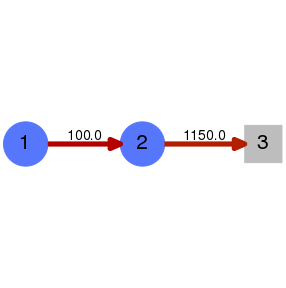

In [13]:
@manipulate for line2_limit in 1000:10:1500
#line2_limit
    f_max[2] = line2_limit
    #Define the optimal power flow (OPF) model
    opf=Model() 
    
    # Define decision variables
    @variables(opf, begin
        g[1:2] >= 0
        w[1:2] >= 0
        f[1:2]
        theta[1:3]
    end)

    # Define the objective function
    @objective(opf,Min,sum(c_g[i] * g[i] for i=1:2) + sum(c_w * w[v] for v=1:2))

    for i in 1:2
        @constraint(opf,  g[i] <= g_max[i] ) #maximum
        @constraint(opf,  g[i] >= g_min[i] ) #minimum
    end

    # Define the constraint on the wind power injections
    for v in 1:2
        @constraint(opf,  w[v] <= w_f_vec[v]); 
    end

    # Define the constraint on the power flows
    for l in 1:2
        @constraint(opf, f[l] <= f_max[l])   # direct flows
        @constraint(opf, f[l] >=  -f_max[l]) # reverse flows
    end

    # Define the power balance constraint
    for b in 1:3
        @constraint(opf, sum(g_map[i,b]* g[i] for i=1:2) + sum(w_map[v,b] * w[v] for v=1:2) + sum(f_map[l,b] * f[l] for l=1:2)>= d_vec[b]); 
    end

    # Calculate f[l]
    for l in 1:2
        @constraint(opf, f[l] == 1/x[l] * sum(f_map[l,b] * theta[b] for b=1:3))   # power flow in every line
    end

    # Slack bus 
    @constraint(opf, theta[1] == 0)  # direct flows

    # Solve statement
    solve(opf)
    writeDot("UC",[1,2,3],[0.0;getvalue(g)],[getvalue(w);0.0],[2,3],[1,2],getvalue(f),f_max,(3,3))
end